[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/rycroft-group/math513/blob/main/1_svd/image_compression.ipynb)

In [1]:
# Necessity libraries
import numpy as np
import matplotlib.pyplot as plt
from skimage.io import imread

# Optional: a library for plotting with LaTeX-like 
# styles nicer formatted figures
# Warning: need to have LaTeX installed
import scienceplots
plt.style.use(['science'])

# Image compression using SVD

This notebook was adapted from Code 1.1 of Chapter 1 Singular value decomposition in "Data-Driven Science and Engineering" by Steve Brunton and Nathan Kutz. Part of the notebook is also adapted from [Harvard AM205 Group Activity "SVD for image processing"](https://github.com/chr1shr/am205_g_activities/tree/master/svd_image_processing) by Jovana Andrejevic.

## Grayscale image

First, we load the image, convert it grayscale so that 256 bit -> double.
By the way, this is Batti. He’s an Italian cat, and he likes to roam around the mountains.

Image dimensions: (960, 700)


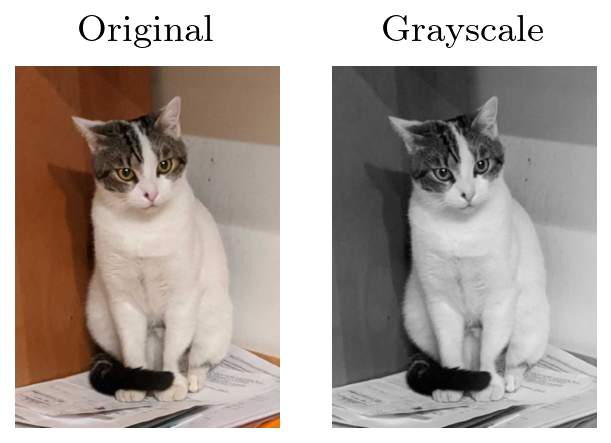

In [2]:
from skimage.color import rgb2gray

A = imread('figs/batti.jpg') # load the image
A_gray = rgb2gray(A).astype(np.float64) # convert to grayscale and ensure double precision
nx, ny = A_gray.shape[0], A_gray.shape[1]
print("Image dimensions:", A_gray.shape)

# Plot Batti
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(2.5, 2), dpi=300)
# Plot the original image
ax1.imshow(A)
ax1.set_title("Original", size=9)
ax1.axis("off")
# Plot the grayscale image
ax2.imshow(A_gray, cmap='gray')
ax2.set_title("Grayscale", size=9)
ax2.axis("off")

plt.show()

Next, we define a function ```rank_approx(A, r)``` which accepts a grayscale matrix $A$ and a maximum rank $r$, and returns the $r$-th low-rank approximation of the matrix.

In [11]:
def rank_approx(A, r):
    # SVD
    U, s, Vt = np.linalg.svd(A, full_matrices=False)
    S = np.diag(s) # turn s into a diagonal matrix
    # Approximate matrix with truncated SVD
    A_r = U[:, :r] @ S[:r, :r] @ Vt[:r, :]
    return A_r

Finally, we reconstruct the approximated grayscale image based on the rank $r$.

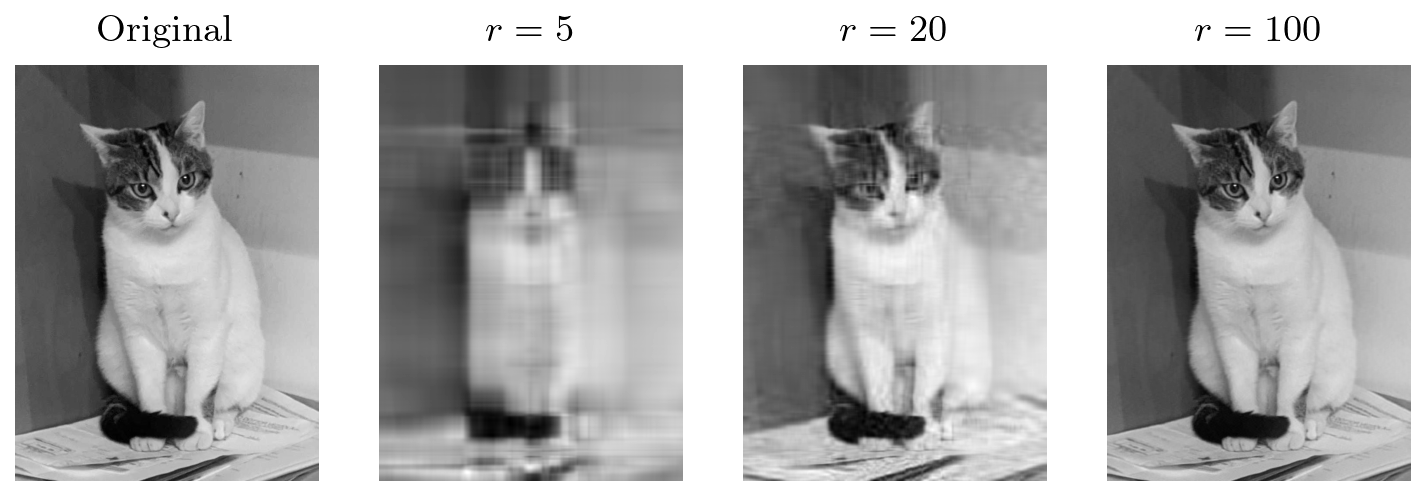

In [4]:
ranks = [5, 20, 100] # list of ranks to approximate
fig, axes = plt.subplots(1, len(ranks)+1, figsize=(6, 2), dpi=300)

# Plot the original grayscale image
axes[0].imshow(A_gray, cmap='gray')
axes[0].set_title('Original', size=9)
axes[0].axis('off')

# Plot the rank-k approximations
for i, rank in enumerate(ranks):
    A_r = rank_approx(A_gray, rank)
    axes[i+1].imshow(A_r, cmap='gray')
    axes[i+1].set_title('$r={}$'.format(rank), size=9)
    axes[i+1].axis('off')

# plt.savefig('results/batti_compression.pdf', bbox_inches='tight', dpi=300)
plt.show()

We can also run the following widget to interactively vary the rank and visualize the resulting reconstruction.

In [5]:
import ipywidgets as widgets
from ipywidgets import interactive

rmax = 120 
rank_slider = widgets.IntSlider(
    value=1, min=1, max=rmax, step=1,
    description='rank:', continuous_update=False
)

def rank_slider_plot(r=1):
    plt.close()
    A_r = rank_approx(A_gray, r)

    # Plot the original and compressed images.
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(2.5, 2), dpi=300)
    ax1.imshow(A_gray, cmap='gray')
    ax1.set_title("Original", size=9)
    ax1.axis("off")

    ax2.imshow(A_r, cmap='gray')
    ax2.set_title("Reconstruction", size=9)
    ax2.axis("off")
    plt.show()

interactive_plot = interactive(rank_slider_plot, r=rank_slider)
output = interactive_plot.children[-1]
interactive_plot


interactive(children=(IntSlider(value=1, continuous_update=False, description='rank:', max=120, min=1), Output…

We can quantify our reconstruction with the following two metrics: the fraction of our image reconstructed by a rank-$r$ approximation, and the fraction of storage space required.

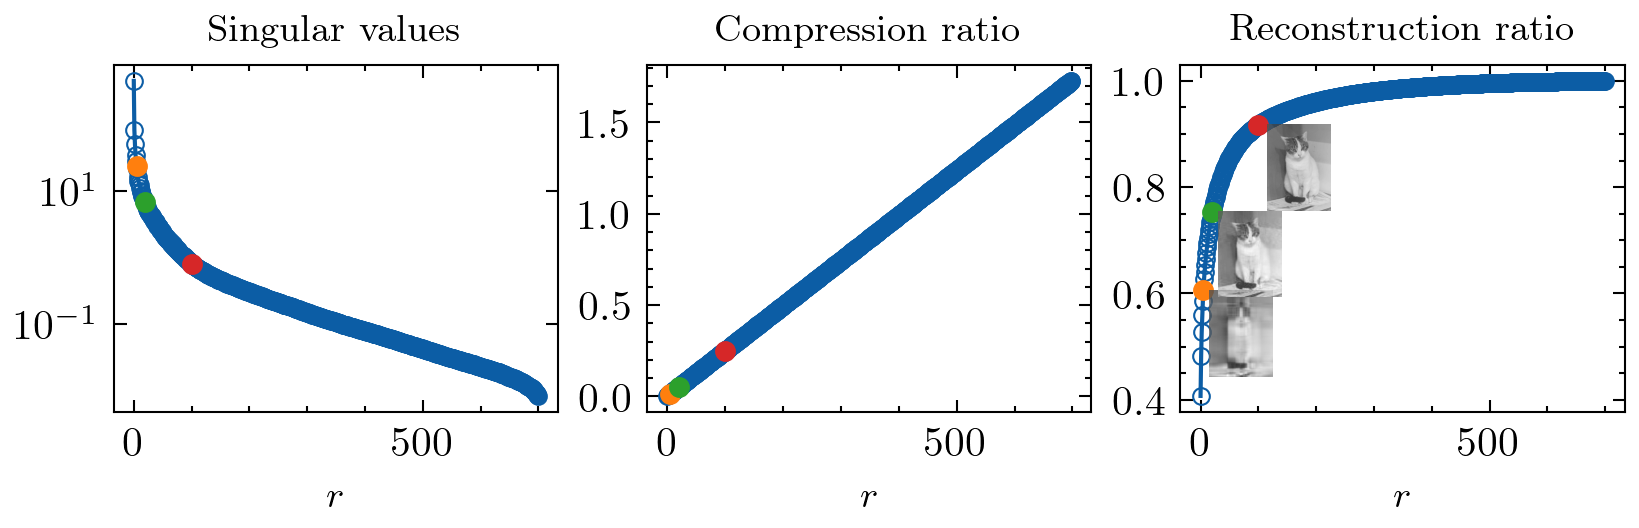

In [6]:
# SVD
U, s, Vt = np.linalg.svd(A_gray, full_matrices=False)

fig, axes = plt.subplots(1, 3, figsize=(6.5, 1.5), dpi=300)

# First plot the singular values
axes[0].semilogy(s, '-o', lw=1, markersize=4, mfc='none', mew=0.5)
# Highlight r = 5, 20, 100
colors = ['tab:orange', 'tab:green', 'tab:red']
for i, r in enumerate(ranks):
    axes[0].plot(r, s[r], 'o', color=colors[i], markersize=4)
axes[0].set_title('Singular values', size=9)
axes[0].set_xlabel('$r$', size=9)

# Second plot the fraction of storage space
storage_fraction = [(nx + ny + 1)*r / (nx * ny) for r in range(1, s.shape[0])]
axes[1].plot(storage_fraction, '-o', lw=1, markersize=4, mfc='none', mew=0.5)
# Highlight r = 5, 20, 100
for i, r in enumerate(ranks):
    axes[1].plot(r, storage_fraction[r], 'o', color=colors[i], markersize=4)
axes[1].set_title('Compression ratio', size=9)
axes[1].set_xlabel('$r$', size=9)

# Third plot the cumulative sum of singular values
cumulative_sum_frac = np.cumsum(s) / np.sum(s)
axes[2].plot(cumulative_sum_frac, '-o', lw=1, markersize=4, mfc='none', mew=0.5)
# Highlight r = 5, 20, 100
for i, r in enumerate(ranks):
    axes[2].plot(r, cumulative_sum_frac[r], 'o', color=colors[i], markersize=4)
axes[2].set_title('Reconstruction ratio', size=9)
axes[2].set_xlabel('$r$', size=9)

# Optional: make inset
# pPlot each image at its corresponding location
inx = [7, 22, 98]
iny = [0.1, 0.33, 0.58]
for i, r in enumerate(ranks):
    # Create an inset axis at the location of the highlighted r
    axin = axes[2].inset_axes([inx[i]/len(s), iny[i], 0.25, 0.25], transform=axes[2].transAxes)
    # Plot the r-reconstruction
    A_r = rank_approx(A_gray, r)
    axin.imshow(A_r, cmap='gray', alpha=0.8)
    axin.axis('off')

# plt.savefig('results/batti_svd.pdf', bbox_inches='tight', dpi=300)
plt.show()

Batti is happy that he can be reconstructed with fewer singular values!

![Batti happy](figs/batti_crazy.gif)

## RGB image

We read in a test image and convert to a $[0,1]$ scale before performing any arithmetic.

Image dimensions: (960, 700, 3)


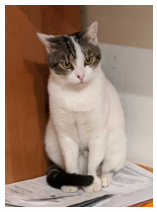

In [7]:
A = imread('figs/batti.jpg')
im = A.astype(np.float64)/255.

print("Image dimensions:",im.shape)

plt.imshow(im)
plt.axis('off')
plt.show()

Next, we vertically stack the color channels to form a $3m\times{n}$ image, where the $n$ columns of the image represent our samples, and center the image about its mean to obtain the matrix $A$.

In [8]:
m, n, p = im.shape
A3 = np.vstack([im[:, :, 0],
                im[:, :, 1],
                im[:, :, 2]])

Now, we need to reconstruct the $(3m,n)$ back to an $(m,n)$ image with 3 color channels.

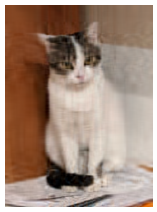

In [9]:
def reconstruct(A3_r):
    m = A3_r.shape[0] // 3  # the leading dimension of a single channel
    A_r = np.stack([A3_r[:m, :], A3_r[m:2*m, :], A3_r[2*m:, :]], axis=2)
    
    # Truncate values and return the reconstructed image.
    A_r[A_r < 0] = 0
    A_r[A_r > 1] = 1
    return A_r

# Run a test:
r = 20
A3_r = rank_approx(A3, r)
imr = reconstruct(A3_r)

plt.imshow(imr)
plt.axis('off')
plt.show()

We can do the slider interaction again.

In [10]:
import ipywidgets as widgets
from ipywidgets import interactive

rmax = 120 
rank_slider = widgets.IntSlider(
    value=1, min=1, max=rmax, step=1,
    description='rank:', continuous_update=False
)

def rank_slider_plot(r=1):
    plt.close()
    A3_r = rank_approx(A3, r)
    A_r = reconstruct(A3_r)

    # Plot the original and compressed images.
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(2.5, 2), dpi=300)
    ax1.imshow(A)
    ax1.set_title("Original", size=9)
    ax1.axis("off")

    ax2.imshow(A_r)
    ax2.set_title("Reconstruction", size=9)
    ax2.axis("off")
    plt.show()

interactive_plot = interactive(rank_slider_plot, r=rank_slider)
output = interactive_plot.children[-1]
interactive_plot


interactive(children=(IntSlider(value=1, continuous_update=False, description='rank:', max=120, min=1), Output…